In [1]:
import os
import re
import json
import logging
import asyncio
import numpy as np
import pandas as pd
from groq import Groq
from dotenv import load_dotenv
from dataclasses import dataclass
from langchain_groq import ChatGroq
from datetime import date, datetime
from langchain_core.tools import tool
from pydantic import BaseModel, Field
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages
from concurrent.futures import ThreadPoolExecutor
from typing import Dict, List, Tuple, Optional, Any
from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph import Graph, StateGraph, END, START
from typing import TypedDict, Annotated
from langchain_core.messages import BaseMessage, HumanMessage
import re

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

In [2]:
load_dotenv()

True

In [3]:
llm = ChatGroq(
    model= "deepseek-r1-distill-llama-70b",  #"openai/gpt-oss-120b", #"gemma2-9b-it", #
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2
)

In [4]:
from pydantic import BaseModel, Field

class ColumnSchema(BaseModel):
    transaction_date: str = Field(..., description="Column name for transaction date")
    debit: str = Field(..., description="Column name for debit amount")
    credit: str = Field(..., description="Column name for credit amount")

In [5]:
from typing import List, Optional
from pydantic import BaseModel, Field
import pandas as pd

class BankReconciliationState(BaseModel):
    bank_data: str
    erp_data: str
    bank_columns: Optional[ColumnSchema] = None
    erp_columns: Optional[ColumnSchema] = None
    bank_chunk_data: List[pd.DataFrame] = Field(default_factory=list)
    erp_chunk_data: List[pd.DataFrame] = Field(default_factory=list)
    erp_chunk_amount: Optional[float] = 0
    bank_chunk_amount: Optional[float] = 0
    erp_total_amount: Optional[float] = 0
    bank_total_amount: Optional[float] = 0
    messages: Optional[str] = None
    index: Optional[int] = 0  # ✅ corrected

    model_config = {
        "arbitrary_types_allowed": True  # allows pd.DataFrame
    }


In [6]:
structured_model_column = llm.with_structured_output(ColumnSchema)

In [7]:
# Reusable function for detecting columns
def detect_columns(file_path: str):
    df = pd.read_csv(file_path)
    subset_data = df.head(5)
    prompt = f"""
    From the following dataset, identify which column corresponds to:
    - transaction_date
    - debit
    - credit

    Dataset sample:
    {subset_data.to_dict(orient='records')}
    """
    return structured_model_column.invoke(prompt)


# Node: find columns in bank dataset
def find_bank_columns(state: BankReconciliationState):
    result = detect_columns(state.bank_data)
    return {"bank_columns": result}


# Node: find columns in ERP dataset
def find_erp_columns(state: BankReconciliationState):
    result = detect_columns(state.erp_data)
    return {"erp_columns": result}



In [8]:
import pandas as pd

def chunk_dataset(state: BankReconciliationState):
    """
    Split both datasets into chunks of up to 3 days each.
    Keep only 'transaction_date', 'debit', 'credit' columns in state data.
    """

    bank_date_column = state.bank_columns.transaction_date
    erp_date_column = state.erp_columns.transaction_date

    # Load datasets
    bank_df = pd.read_csv(state.bank_data)
    erp_df = pd.read_csv(state.erp_data)

    # Ensure transaction_date is datetime
    bank_df[bank_date_column] = pd.to_datetime(bank_df[bank_date_column], errors="coerce")
    erp_df[erp_date_column] = pd.to_datetime(erp_df[erp_date_column], errors="coerce")

    # Drop invalid dates
    bank_df = bank_df.dropna(subset=[bank_date_column])
    erp_df = erp_df.dropna(subset=[erp_date_column])

    # Helper function to chunk by 3-day windows
    def split_by_days(df, date_column):
        if df.empty:
            return []
        df = df.sort_values(by=date_column).reset_index(drop=True)
        min_date, max_date = df[date_column].min(), df[date_column].max()

        if (max_date - min_date).days < 2:
            return [df]

        chunks = []
        start_date = min_date
        while start_date <= max_date:
            end_date = start_date + pd.Timedelta(days=1)
            chunk = df[(df[date_column] >= start_date) & (df[date_column] <= end_date)]
            if not chunk.empty:
                chunks.append(chunk.reset_index(drop=True))
            start_date = end_date + pd.Timedelta(days=1)
        return chunks

    # Split datasets
    bank_chunks = split_by_days(bank_df, bank_date_column)
    erp_chunks = split_by_days(erp_df, erp_date_column)

    # Ensure both have the same number of chunks (pad smaller with empty DataFrames)
    max_chunks = max(len(bank_chunks), len(erp_chunks))
    while len(bank_chunks) < max_chunks:
        bank_chunks.append(pd.DataFrame(columns=bank_df.columns))
    while len(erp_chunks) < max_chunks:
        erp_chunks.append(pd.DataFrame(columns=erp_df.columns))

    # ✅ Keep only required columns in each chunk
    required_cols = [bank_date_column, state.bank_columns.debit, state.bank_columns.credit]
    state.bank_chunk_data = [chunk[required_cols].copy() for chunk in bank_chunks]
    state.erp_chunk_data = [chunk[[erp_date_column, state.erp_columns.debit, state.erp_columns.credit]].copy() for chunk in erp_chunks]

    return {
        "bank_chunk_data": state.bank_chunk_data,
        "erp_chunk_data": state.erp_chunk_data
    }


In [9]:
def reconciliations(state: BankReconciliationState):
    """LLM-powered reconciliation function that generates Python code for calculations."""
    index = state.index
    print("================================: ", index)
    # Take first chunk of each dataset
    bank_df = state.bank_chunk_data[index]
    erp_df = state.erp_chunk_data[index]
    
    # Extract dynamic column names from state
    bank_transaction_date = state.bank_columns.transaction_date
    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_transaction_date = state.erp_columns.transaction_date
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit
    
    # Create a detailed prompt for the LLM to generate Python code
    bank_sample = bank_df.head(5).to_string() if not bank_df.empty else "No data"
    erp_sample = erp_df.head(5).to_string() if not erp_df.empty else "No data"
    
    prompt = f"""You are a financial analyst. Write Python code to calculate net balance for two datasets.

        Bank dataset columns:
        - Transaction date: "{bank_transaction_date}"
        - Debit: "{bank_debit}" 
        - Credit: "{bank_credit}"

        ERP dataset columns:
        - Transaction date: "{erp_transaction_date}"
        - Debit: "{erp_debit}"
        - Credit: "{erp_credit}"

        Sample bank data:
        {bank_sample}

        Sample ERP data:
        {erp_sample}

        Task: Write Python code to calculate net balance for bank dataset is (total_credit - total_debit) and net balance for erp dataset is (total_debit - total_credit).

        Requirements:
        1. Convert columns to numeric, handling commas and NaN values as 0
        2. Calculate: bank_net_balance = bank_total_credit - bank_total_debit
        3. Calculate: erp_net_balance = erp_total_debit - erp_total_credit 
        4. Use the exact column names provided above
        5. Return only executable Python code, no explanations or markdown

        Example format:
        # Clean bank data
        bank_df['{bank_credit}'] = pd.to_numeric(bank_df['{bank_credit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
        bank_df['{bank_debit}'] = pd.to_numeric(bank_df['{bank_debit}'].astype(str).str.replace(',', ''), errors='coerce').fillna(0)
        bank_total_credit = bank_df['{bank_credit}'].sum()
        bank_total_debit = bank_df['{bank_debit}'].sum()
        bank_net_balance = bank_total_credit - bank_total_debit

        # Clean ERP data
        erp_df['{erp_credit}'] = pd.to_numeric(erp_df['{erp_credit}'], errors='coerce').fillna(0)
        erp_df['{erp_debit}'] = pd.to_numeric(erp_df['{erp_debit}'], errors='coerce').fillna(0)
        erp_total_credit = erp_df['{erp_credit}'].sum()
        erp_total_debit = erp_df['{erp_debit}'].sum()
        erp_net_balance = erp_total_debit - erp_total_credit"""
    
    try:
        # Use regular LLM instead of structured output to avoid tool choice errors
        from langchain_core.messages import HumanMessage
        response = llm.invoke([HumanMessage(content=prompt)])
        code = response.content
        
        # Clean the response (remove markdown code blocks if present)
        code = re.sub(r'```python\n?', '', code)
        code = re.sub(r'\n?```', '', code)
        code = code.strip()
        
        print(f"🤖 LLM Generated Reconciliation Code:")
        print(code)
        print("=" * 50)
        
        # Execute the LLM-generated code in a safe scope
        local_vars = {"bank_df": bank_df.copy(), "erp_df": erp_df.copy(), "pd": pd}
        exec(code, {"pd": pd}, local_vars)
        
        # Extract variables from executed code
        bank_net_balance = local_vars.get("bank_net_balance")
        erp_net_balance = local_vars.get("erp_net_balance")
        
        if bank_net_balance is None or erp_net_balance is None:
            raise ValueError("LLM code did not produce required variables")
        
        # Save results in state
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 LLM Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
        
    except Exception as e:
        print(f"⚠️ LLM calculation failed: {e}")
        print("🔄 Falling back to hardcoded calculation...")
        
        # Fallback to hardcoded calculation if LLM fails
        bank_df[bank_credit] = pd.to_numeric(bank_df[bank_credit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_df[bank_debit] = pd.to_numeric(bank_df[bank_debit].astype(str).str.replace(',', '').replace('nan', '0'), errors='coerce').fillna(0)
        bank_total_credit = bank_df[bank_credit].sum()
        bank_total_debit = bank_df[bank_debit].sum()
        bank_net_balance = bank_total_credit - bank_total_debit
        
        erp_df[erp_credit] = pd.to_numeric(erp_df[erp_credit], errors='coerce').fillna(0)
        erp_df[erp_debit] = pd.to_numeric(erp_df[erp_debit], errors='coerce').fillna(0)
        erp_total_credit = erp_df[erp_credit].sum()
        erp_total_debit = erp_df[erp_debit].sum()
        erp_net_balance = erp_total_debit - erp_total_credit
        
        state.bank_chunk_amount = bank_net_balance
        state.erp_chunk_amount = erp_net_balance
        
        print(f"💰 Fallback Calculated - Bank total: {bank_net_balance}, ERP total: {erp_net_balance}")
    
    return state

print("✅ Helper functions defined")


✅ Helper functions defined


In [10]:
def compare_chunk_balances(state: BankReconciliationState):
    """
    Compare the latest Bank and ERP chunk balances.
    """
    try:
        bank_val = state.bank_chunk_amount

        erp_val = state.erp_chunk_amount
        index = state.index
        if bank_val == erp_val:
            state.bank_total_amount += state.bank_chunk_amount
            state.erp_total_amount += state.erp_chunk_amount
            state.bank_chunk_amount = 0
            state.erp_chunk_amount = 0
            state.index += 1
            state.messages = "reconciliations"
            # # ✅ Clear processed chunks
            # del state.bank_chunk_data[index]
            # del state.erp_chunk_data[index]

            return state
        else:
            state.messages = "eliminate_matching_rows"
            return state
    except Exception as e:
        return {"error": str(e)}

In [11]:
# ✅ Clean data
def clean_dataframe(df, debit_col, credit_col):
    df = df.copy()

    # Fill None/NaN with 0
    df[debit_col] = df[debit_col].fillna(0)
    df[credit_col] = df[credit_col].fillna(0)

    # Remove commas, spaces inside numbers, strip spaces, and ensure numeric
    def clean_numeric(series):
        return (
            series.astype(str)
            .str.replace(",", "", regex=True)   # remove commas
            .str.replace(" ", "", regex=True)   # remove spaces in numbers
            .str.strip()                        # remove leading/trailing spaces
            .replace("", "0")                   # replace empty strings with 0
            .astype(float)                      # convert to float
        )

    df[debit_col] = clean_numeric(df[debit_col])
    df[credit_col] = clean_numeric(df[credit_col])

    return df


def eliminate_matching_rows(state: BankReconciliationState):
    """
    Bank reconciliation:
    1. Count Bank & ERP totals.
    2. Eliminate rows where ERP credit = Bank debit and ERP debit = Bank credit.
    3. Adjust balances with remaining unmatched rows.
    4. Clean data: treat None/NaN as 0 and remove commas/spaces.
    """
    index = state.index
    bank_df = state.bank_chunk_data[index]
    erp_df = state.erp_chunk_data[index]

    # ✅ Extract dynamic column names from state
    bank_credit = state.bank_columns.credit
    bank_debit = state.bank_columns.debit
    erp_credit = state.erp_columns.credit
    erp_debit = state.erp_columns.debit

    if bank_df is None or erp_df is None:
        return {"messages": ["Missing data in state"]}

    bank_df = clean_dataframe(bank_df, bank_debit, bank_credit)
    erp_df = clean_dataframe(erp_df, erp_debit, erp_credit)

    # ✅ Eliminate exact matches using dynamic column names
    merged = pd.merge(
        bank_df,
        erp_df,
        left_on=[bank_debit, bank_credit],
        right_on=[erp_credit, erp_debit],
        how="outer",
        indicator=True
    )

    unmatched_bank = merged[merged["_merge"] == "left_only"].drop(columns=["_merge"])
    unmatched_erp = merged[merged["_merge"] == "right_only"].drop(columns=["_merge"])

    # ✅ Recalculate balances after removing matched rows
    erp_chunk_amount = (
        state.erp_chunk_amount
        - unmatched_bank[bank_debit].sum()
        + unmatched_bank[bank_credit].sum()
    )

    bank_chunk_amount = (
        state.bank_chunk_amount
        - unmatched_erp[erp_credit].sum()
        + unmatched_erp[erp_debit].sum()
    )

    # ✅ Update state
    state.bank_total_amount += bank_chunk_amount
    state.erp_total_amount += erp_chunk_amount
    state.bank_chunk_amount = 0
    state.erp_chunk_amount = 0
    state.index += 1
    # # ✅ Clear processed chunks
    # del state.bank_chunk_data[index]
    # del state.erp_chunk_data[index]

    print("✅ Updated balances:\nERP:", state.erp_chunk_amount, "\nBank:", state.bank_chunk_amount)
    return state


In [12]:
# Conditional edges
def route_after_comparison(state: BankReconciliationState):
    messages = state.messages
    if "eliminate_matching_rows" in messages:
        return "eliminate_matching_rows"
    elif "reconciliations" in messages:
        return "reconciliations"
    else:
        return END

In [13]:
# Conditional edges
def chunk_length_check(state: BankReconciliationState):
    index_number = state.index
    chunk_length = max(len(state.bank_chunk_data), len(state.erp_chunk_data))
    if index_number < chunk_length:
        return {"messages": "reconciliations"}
    else:
        return END

In [14]:
# Conditional edges
def route_length_check(state: BankReconciliationState):
    messages = state.messages
    if "reconciliations" in messages:
        return "reconciliations"
    else:
        return END

In [15]:
# # --- Build workflow ---
# graph = StateGraph(BankReconciliationState)

# # Add nodes
# graph.add_node("find_bank_columns", find_bank_columns)
# graph.add_node("find_erp_columns", find_erp_columns)
# graph.add_node("chunk_dataset", chunk_dataset)
# graph.add_node("reconciliations", reconciliations)
# graph.add_node("compare_chunk_balances", compare_chunk_balances)
# graph.add_node("eliminate_matching_rows", eliminate_matching_rows)

# # Connect edges
# graph.add_edge(START, "find_bank_columns")
# graph.add_edge(START, "find_erp_columns")
# graph.add_edge("find_bank_columns", "chunk_dataset")
# graph.add_edge("find_erp_columns", "chunk_dataset")
# graph.add_edge("chunk_dataset", "reconciliations")
# graph.add_edge("reconciliations", "compare_chunk_balances")

# graph.add_conditional_edges(
#     "compare_chunk_balances",
#     route_after_comparison,
#     {
#         "reconciliations": "reconciliations",
#         "eliminate_matching_rows": "eliminate_matching_rows"
#     }
# )

# graph.add_edge("compare_chunk_balances", END)

# # Compile workflow
# workflow = graph.compile()
# print("✅ Workflow built and compiled")

In [16]:
import sys
sys.setrecursionlimit(1000)  # or higher


In [17]:
# --- Build workflow ---
graph = StateGraph(BankReconciliationState)

# Add nodes
graph.add_node("find_bank_columns", find_bank_columns)
graph.add_node("find_erp_columns", find_erp_columns)
graph.add_node("chunk_dataset", chunk_dataset)
graph.add_node("reconciliations", reconciliations)
graph.add_node("compare_chunk_balances", compare_chunk_balances)
graph.add_node("eliminate_matching_rows", eliminate_matching_rows)
graph.add_node("chunk_length_check", chunk_length_check)
# Connect edges
graph.add_edge(START, "find_bank_columns")
graph.add_edge(START, "find_erp_columns")
graph.add_edge("find_bank_columns", "chunk_dataset")
graph.add_edge("find_erp_columns", "chunk_dataset")
graph.add_edge("chunk_dataset", "reconciliations")
graph.add_edge("reconciliations", "compare_chunk_balances")

graph.add_conditional_edges(
    "compare_chunk_balances",
    route_after_comparison,
    {
        "reconciliations": "reconciliations",
        "eliminate_matching_rows": "eliminate_matching_rows",
        END: END
    }
)

graph.add_edge("eliminate_matching_rows", "chunk_length_check")
graph.add_conditional_edges(
    "chunk_length_check",
    route_length_check,
    {
        "reconciliations": "reconciliations",
        END: END
    }
)
# graph.add_edge("compare_chunk_balances", END)

# Compile workflow
workflow = graph.compile()
print("✅ Workflow built and compiled")

✅ Workflow built and compiled


INFO:pyppeteer.launcher:Browser listening on: ws://127.0.0.1:46227/devtools/browser/7d234e41-40c3-48c1-8719-5b6beb37fdf1
INFO:pyppeteer.launcher:terminate chrome process...


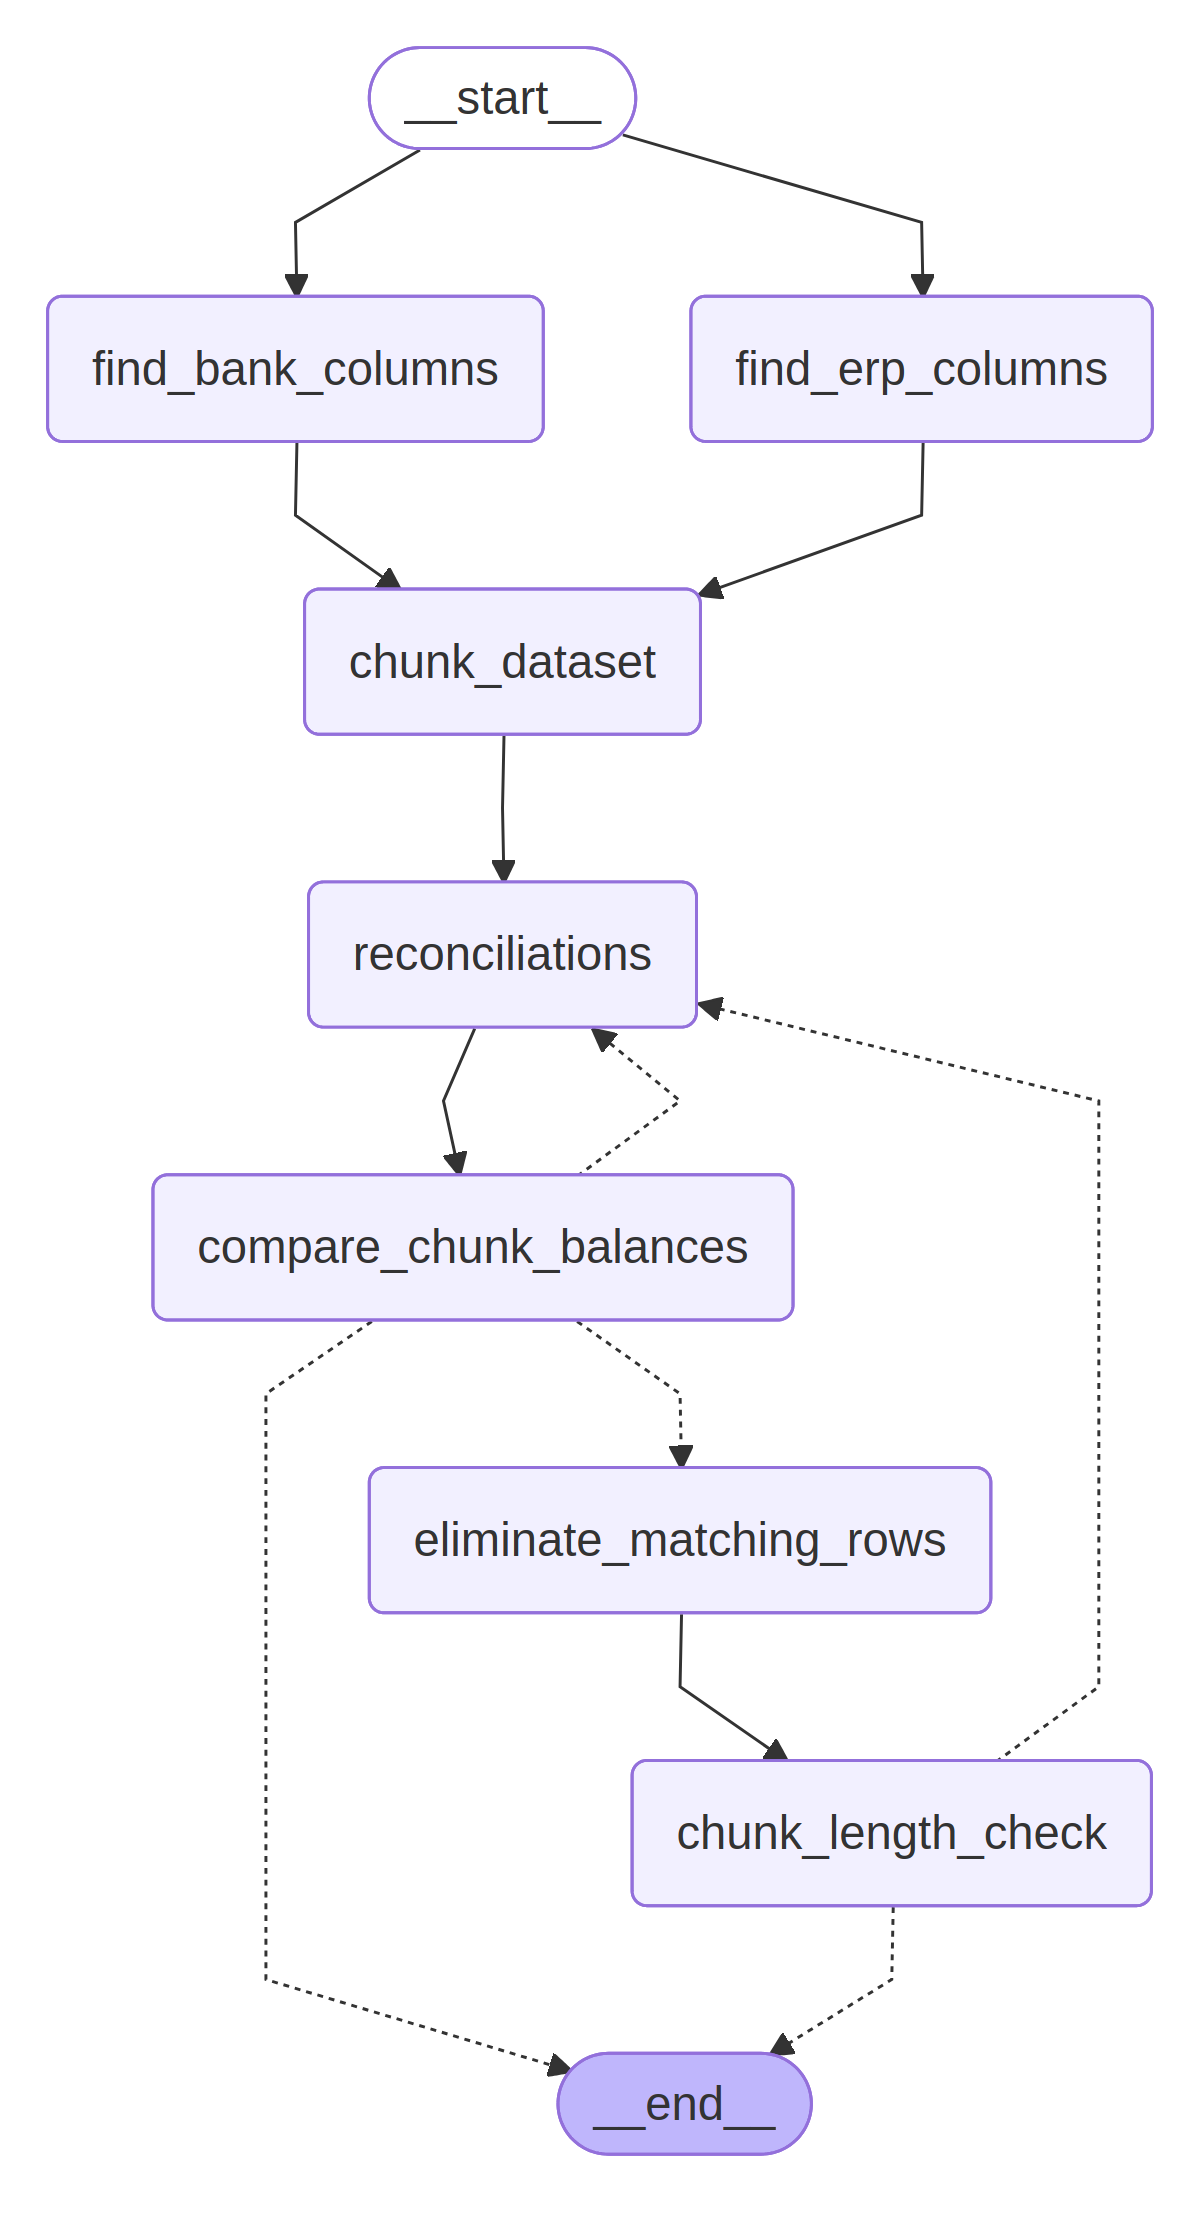

In [18]:
# from IPython.display import Image, display
# Image(workflow.get_graph().draw_mermaid_png())


import nest_asyncio
from IPython.display import Image, display
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod

nest_asyncio.apply()  # patch the running event loop

# Render workflow graph locally
png = workflow.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)
display(Image(png))


In [19]:
initial_state = {
    "erp_data": "Dataset/Pubali # 41774-ERP.csv",
    "bank_data": "Dataset/Pubali # 41774.csv"
}

try:
    result = workflow.invoke(initial_state, {"recursion_limit": 100})
    print("✅ Workflow executed successfully")
    
except Exception as e:
    print(f"❌ Error running workflow: {e}")
    import traceback
    traceback.print_exc()


INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 16.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 429 Too Many Requests"
INFO:groq._base_client:Retrying request to /openai/v1/chat/completions in 16.000000 seconds
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"
INFO:httpx:HTTP Request: POST https://api.groq.com/openai/v1/chat/completions "HTTP/1.1 200 OK"


KeyboardInterrupt: 

In [ ]:
len(result["bank_chunk_data"])

In [ ]:
df = pd.DataFrame(result["bank_chunk_data"][1])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["CREDIT"] = (
    df["CREDIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["CREDIT"].sum()

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["DEBIT"] = (
    df["DEBIT"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_DEBIT = df["DEBIT"].sum()

print(total_credit - total_DEBIT)

In [ ]:
df = pd.DataFrame(result["erp_chunk_data"][1])

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Credit"] = (
    df["Credit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_credit = df["Credit"].sum()

# Convert CREDIT column to numeric (removes commas, handles NaN as 0)
df["Debit"] = (
    df["Debit"]
    .astype(str)                 # ensure string for replace
    .str.replace(",", "", regex=False)  # remove commas
    .replace("nan", "0")         # handle string "nan"
    .astype(float)               # convert to float
    .fillna(0)                   # handle actual NaN
)

# Now sum the CREDIT column
total_Debit = df["Debit"].sum()

print(total_Debit-total_credit)